# 04 - Modèle Baseline: Entraînement LeNet CNN

**Objectif:** Reproduire F1 = 0.31 (Model 132 original)

**Architecture:** LeNet | **Images:** 256×256 | **Batch:** 128 | **Époques:** 20

**🔵 Optimisé Google Colab + Keras 3**

---

## 🔧 Environnement

In [1]:
import sys, os
from pathlib import Path

IS_COLAB = 'google.colab' in sys.modules
if IS_COLAB:
    print("🔵 Google Colab")
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    PROJECT_ROOT = Path('/content/drive/MyDrive/sep25_alt1_mle_ds_rakuten')
    os.chdir(PROJECT_ROOT)
else:
    print("🟢 Local")
    PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
    os.chdir(PROJECT_ROOT)

print(f"📁 {PROJECT_ROOT}")

🔵 Google Colab
Mounted at /content/drive
📁 /content/drive/MyDrive/sep25_alt1_mle_ds_rakuten


## 📦 Imports

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
import pickle, json, shutil
from datetime import datetime
import warnings; warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

np.random.seed(42)
tf.random.set_seed(42)

# GPU check
gpus = tf.config.list_physical_devices('GPU')
print(f"TensorFlow: {tf.__version__}")
if gpus:
    print(f"✅ GPU: {gpus}")
else:
    print("❌ Pas de GPU! → Runtime > Change runtime type > T4 GPU")

INPUT_DIR  = Path('output/03_preprocessing_resampling')
OUTPUT_DIR = Path('output/04_baseline_lenet')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("\n✅ Imports OK")

TensorFlow: 2.19.0
❌ Pas de GPU! → Runtime > Change runtime type > T4 GPU

✅ Imports OK


## 🚀 Copie Images → SSD Colab

**CRITIQUE:** Les images sont sur Drive (lent). On les copie sur le SSD local de Colab (rapide).

- **Sans cette étape:** ~9h par époque ❌
- **Avec cette étape:** ~20-40 min par époque ✅

⏱️ La copie prend 10-20 min **une seule fois par session**.

In [3]:
DRIVE_IMAGE_DIR = Path('output/02_preprocessing_images/images_zoomed')
SSD_IMAGE_DIR   = Path('/content/images_zoomed')

if IS_COLAB:
    if not SSD_IMAGE_DIR.exists():
        print(f"📦 Copie Drive → SSD Colab...")
        print(f"   Source: {DRIVE_IMAGE_DIR}")
        print(f"   Dest:   {SSD_IMAGE_DIR}")
        print(f"   ⏱️  ~10-20 minutes, une seule fois par session\n")
        shutil.copytree(src=DRIVE_IMAGE_DIR, dst=SSD_IMAGE_DIR)
        print(f"\n✅ Copie terminée!")
    else:
        print(f"✅ Images déjà sur SSD: {SSD_IMAGE_DIR}")
    IMAGE_DIR = SSD_IMAGE_DIR
else:
    # Local: use Drive images directly (fast local disk)
    IMAGE_DIR = DRIVE_IMAGE_DIR

# Verify
n_classes_found = len(list(IMAGE_DIR.iterdir())) if IMAGE_DIR.exists() else 0
print(f"🚀 IMAGE_DIR = {IMAGE_DIR}")
print(f"   Dossiers classes trouvés: {n_classes_found}")

📦 Copie Drive → SSD Colab...
   Source: output/02_preprocessing_images/images_zoomed
   Dest:   /content/images_zoomed
   ⏱️  ~10-20 minutes, une seule fois par session


✅ Copie terminée!
🚀 IMAGE_DIR = /content/images_zoomed
   Dossiers classes trouvés: 27


## ⚙️ Configuration

In [4]:
MODEL_ID = "lenet_baseline_001"

CONFIG = {
    'image_size'      : (256, 256, 3),
    'batch_size'      : 128,
    'epochs'          : 20,
    'start_lr'        : 0.001,
    'lr_decay_factor' : 0.9,
    'lr_decay_step'   : 3,
}

AUGMENTATION = {
    'rescale'            : 1./255,
    'rotation_range'     : 20,
    'width_shift_range'  : 0.2,
    'height_shift_range' : 0.2,
    'shear_range'        : 5,
    'zoom_range'         : 0.1,
    'horizontal_flip'    : True,
    'vertical_flip'      : False,
}

print(f"Image: {CONFIG['image_size'][:2]} | Batch: {CONFIG['batch_size']} | Époques: {CONFIG['epochs']}")
print(f"LR: {CONFIG['start_lr']} | Decay: ×{CONFIG['lr_decay_factor']} every {CONFIG['lr_decay_step']} epochs")

Image: (256, 256) | Batch: 128 | Époques: 20
LR: 0.001 | Decay: ×0.9 every 3 epochs


In [5]:
# Labels des catégories
prdtypecode_labels = {
    10: "Livre usagé",
    40: "Jeux vidéo et accessoires tech",
    50: "Accessoires de console",
    60: "Console de jeux vidéo",
    1140: "Statuette / Figurine",
    1160: "Cartes collectionnables",
    1180: "Jeux de table",
    1280: "Jouets enfants et costumes",
    1281: "Jeux de société",
    1300: "Jouets électroniques",
    1301: "Bas et chaussettes",
    1302: "Jeux extérieurs et vêtements",
    1320: "Articles pour bébé",
    1560: "Meubles intérieurs",
    1920: "Mobilier de chambre",
    1940: "Ustensiles de cuisine",
    2060: "Décoration intérieure",
    2220: "Produits pour animaux",
    2280: "Magazines et journaux",
    2403: "Livres, magazines et BD",
    2462: "Jeux d'occasion",
    2522: "Matériel de bureau",
    2582: "Mobilier de jardin",
    2583: "Équipement de piscine",
    2585: "Outillage et bricolage",
    2705: "Livre nouveau",
    2905: "Jeux pour PC"
}

print("✅ Labels définis")

✅ Labels définis


## 📊 Chargement Données

In [6]:
df_train = pd.read_csv(INPUT_DIR / 'df_train.csv', index_col=0)
df_val   = pd.read_csv(INPUT_DIR / 'df_val.csv',   index_col=0)
df_test  = pd.read_csv(INPUT_DIR / 'df_test.csv',  index_col=0)

# prdtypecode doit être string pour flow_from_dataframe
for df in [df_train, df_val, df_test]:
    df['prdtypecode'] = df['prdtypecode'].astype(str)

classes     = sorted(df_train['prdtypecode'].unique(), key=lambda x: int(x))
num_classes = len(classes)

print(f"Train: {len(df_train):,} | Val: {len(df_val):,} | Test: {len(df_test):,}")
print(f"Classes: {num_classes}")

Train: 109,566 | Val: 8,492 | Test: 8,492
Classes: 27


## 🖼️ Générateurs

In [7]:
train_datagen = ImageDataGenerator(**AUGMENTATION)
train_gen = train_datagen.flow_from_dataframe(
    dataframe=df_train, directory=IMAGE_DIR,
    x_col='imagefile_relative', y_col='prdtypecode',
    target_size=CONFIG['image_size'][:2], batch_size=CONFIG['batch_size'],
    class_mode='categorical', classes=classes, shuffle=True, seed=42
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_gen = val_datagen.flow_from_dataframe(
    dataframe=df_val, directory=IMAGE_DIR,
    x_col='imagefile_relative', y_col='prdtypecode',
    target_size=CONFIG['image_size'][:2], batch_size=CONFIG['batch_size'],
    class_mode='categorical', classes=classes, shuffle=False
)

test_gen = val_datagen.flow_from_dataframe(
    dataframe=df_test, directory=IMAGE_DIR,
    x_col='imagefile_relative', y_col='prdtypecode',
    target_size=CONFIG['image_size'][:2], batch_size=CONFIG['batch_size'],
    class_mode='categorical', classes=classes, shuffle=False
)

print(f"\n✅ Train: {train_gen.samples:,} | Val: {val_gen.samples:,} | Test: {test_gen.samples:,}")

Found 109566 validated image filenames belonging to 27 classes.
Found 8492 validated image filenames belonging to 27 classes.
Found 8492 validated image filenames belonging to 27 classes.

✅ Train: 109,566 | Val: 8,492 | Test: 8,492


## 🏗️ Architecture LeNet

In [8]:
def build_lenet(input_shape, num_classes):
    return Sequential([
        Conv2D(6,  (5,5), activation='relu', input_shape=input_shape),
        AveragePooling2D((2,2)),
        Conv2D(16, (5,5), activation='relu'),
        AveragePooling2D((2,2)),
        Flatten(),
        Dense(120, activation='relu'),
        Dense(84,  activation='relu'),
        Dense(num_classes, activation='softmax')
    ], name='LeNet')

print("✅ LeNet défini")

✅ LeNet défini


## 🔄 Checkpoints

In [9]:
class CheckpointManager:
    def __init__(self, model_id, output_dir):
        self.model_id     = model_id
        self.output_dir   = Path(output_dir)
        self.model_path   = self.output_dir / f"{model_id}.keras"
        self.history_path = self.output_dir / f"{model_id}_history.pkl"
        self.log_path     = self.output_dir / f"{model_id}_log.json"
        self.log          = self._load_log()

    def _load_log(self):
        if self.log_path.exists():
            with open(self.log_path) as f: return json.load(f)
        return {'model_id': self.model_id, 'created_at': datetime.now().isoformat(),
                'epochs_done': 0, 'best_val_f1': 0.0, 'training_complete': False}

    def save_log(self):
        with open(self.log_path, 'w') as f: json.dump(self.log, f, indent=2)

    def save_model(self, model):
        model.save(self.model_path)
        print(f"💾 Modèle sauvegardé: {self.model_path.name}")

    def load_model(self):
        if self.model_path.exists():
            print(f"📂 Chargement: {self.model_path.name}")
            return load_model(self.model_path)
        return None

    def save_history(self, history_dict):
        existing = self.load_history() or {}
        for k, v in history_dict.items():
            existing[k] = existing.get(k, []) + (v if isinstance(v, list) else list(v))
        with open(self.history_path, 'wb') as f: pickle.dump(existing, f)

    def load_history(self):
        if self.history_path.exists():
            with open(self.history_path, 'rb') as f: return pickle.load(f)
        return None

checkpoint = CheckpointManager(MODEL_ID, OUTPUT_DIR)
print(f"✅ Checkpoint | Epochs faites: {checkpoint.log['epochs_done']} | Best F1: {checkpoint.log['best_val_f1']:.4f}")

✅ Checkpoint | Epochs faites: 20 | Best F1: 0.3365


## 📝 Callbacks

In [10]:
class F1Callback(Callback):
    """
    Calcule le F1 pondéré sur val set après chaque époque.
    Sauvegarde le modèle si F1 s'améliore.
    Pas de custom Keras metric → compatible Keras 3.
    """
    def __init__(self, val_gen, checkpoint):
        super().__init__()
        self.val_gen    = val_gen
        self.checkpoint = checkpoint
        self.best_f1    = checkpoint.log.get('best_val_f1', 0.0)
        self.history    = {'train_loss': [], 'train_acc': [],
                           'val_loss': [],   'val_acc': [], 'val_f1': []}

    def on_epoch_end(self, epoch, logs=None):
        self.val_gen.reset()
        y_pred_proba = self.model.predict(self.val_gen, verbose=0)
        y_pred = np.argmax(y_pred_proba, axis=1)
        y_true = self.val_gen.classes
        val_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        self.history['train_loss'].append(float(logs.get('loss', 0)))
        self.history['train_acc'].append(float(logs.get('accuracy', 0)))
        self.history['val_loss'].append(float(logs.get('val_loss', 0)))
        self.history['val_acc'].append(float(logs.get('val_accuracy', 0)))
        self.history['val_f1'].append(float(val_f1))

        self.checkpoint.log['epochs_done'] = epoch + 1
        self.checkpoint.save_log()

        print(f"  → val_f1: {val_f1:.4f}", end='')

        if val_f1 > self.best_f1:
            self.best_f1 = val_f1
            self.checkpoint.log['best_val_f1'] = float(val_f1)
            self.checkpoint.log['best_epoch']  = epoch + 1
            self.checkpoint.save_model(self.model)
            print(f" 🎯 Nouveau meilleur!", end='')

        print()


def lr_schedule(epoch, lr):
    return CONFIG['start_lr'] * (CONFIG['lr_decay_factor'] ** (epoch // CONFIG['lr_decay_step']))


print("✅ Callbacks définis")

✅ Callbacks définis


## 🏃 Construction Modèle

In [11]:
model = checkpoint.load_model()

if model is None:
    print("🏗️ Construction nouveau LeNet...")
    model = build_lenet(CONFIG['image_size'], num_classes)
    model.compile(
        optimizer=Adam(learning_rate=CONFIG['start_lr']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    print("✅ Compilé")

model.summary()

epochs_done       = checkpoint.log.get('epochs_done', 0)
training_complete = checkpoint.log.get('training_complete', False)
print(f"\n📊 Epochs: {epochs_done}/{CONFIG['epochs']} | Complet: {training_complete}")
print(f"   Best val F1: {checkpoint.log.get('best_val_f1', 0):.4f}")

📂 Chargement: lenet_baseline_001.keras


Model: "LeNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 252, 252, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 126, 126, 6)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 122, 122, 16)   │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 61, 61, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 59536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │     7,144,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 27)             │         2,295 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,479,315 (81.94 MB)

 Trainable params: 7,159,771 (27.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,319,544 (54.62 MB)


📊 Epochs: 20/20 | Complet: True
   Best val F1: 0.3365


## ✅ Vérification Finale Avant Entraînement

In [12]:
print("=" * 50)
print("CHECK AVANT ENTRAÎNEMENT")
print("=" * 50)
print(f"IMAGE_DIR exists:   {IMAGE_DIR.exists()}")
print(f"OUTPUT_DIR exists:  {OUTPUT_DIR.exists()}")
print(f"Train samples:      {len(df_train):,}")
print(f"Val samples:        {len(df_val):,}")
print(f"Checkpoint exists:  {checkpoint.model_path.exists()}")
print(f"Epochs déjà faites: {epochs_done}")
print(f"GPU dispo:          {len(tf.config.list_physical_devices('GPU')) > 0}")
print(f"Images sur SSD:     {str(IMAGE_DIR).startswith('/content/')}")
print("=" * 50)
if not str(IMAGE_DIR).startswith('/content/') and IS_COLAB:
    print("\n⚠️ ATTENTION: Images pas sur SSD! Relancez la cellule 'Copie Images'.")
else:
    print("\n✅ Tout bon - prêt à lancer l'entraînement!")

CHECK AVANT ENTRAÎNEMENT
IMAGE_DIR exists:   True
OUTPUT_DIR exists:  True
Train samples:      109,566
Val samples:        8,492
Checkpoint exists:  True
Epochs déjà faites: 20
GPU dispo:          False
Images sur SSD:     True

✅ Tout bon - prêt à lancer l'entraînement!


## 🚀 Entraînement

**⏱️ ~20-40 min par époque sur GPU T4 (avec images sur SSD)**

In [ ]:
if not training_complete:
    print(f"\n🎯 Démarrage époque {epochs_done + 1}/{CONFIG['epochs']}...\n")

    f1_cb = F1Callback(val_gen, checkpoint)
    callbacks = [
        f1_cb,
        LearningRateScheduler(lr_schedule, verbose=1),
    ]

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=CONFIG['epochs'],
        initial_epoch=epochs_done,
        steps_per_epoch=train_gen.samples // CONFIG['batch_size'],
        validation_steps=val_gen.samples // CONFIG['batch_size'],
        callbacks=callbacks,
        verbose=1
    )

    checkpoint.log['training_complete'] = True
    checkpoint.save_log()
    checkpoint.save_history(f1_cb.history)

    print("\n✅ Entraînement terminé!")
else:
    print("\n⏭️ Entraînement déjà terminé")


🎯 Démarrage époque 1/20...


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/20
855/855 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0835 - loss: 3.3109  → val_f1: 0.1545💾 Modèle sauvegardé: lenet_baseline_001.keras
 🎯 Nouveau meilleur!
855/855 ━━━━━━━━━━━━━━━━━━━━ 993s 1s/step - accuracy: 0.0836 - loss: 3.3106 - val_accuracy: 0.1634 - val_loss: 2.9361 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/20
  1/855 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.1797 - loss: 2.6920  → val_f1: 0.1405
855/855 ━━━━━━━━━━━━━━━━━━━━ 35s 41ms/step - accuracy: 0.1797 - loss: 2.6920 - val_accuracy: 0.1596 - val_loss: 2.9559 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/20
855/855 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1785 - loss: 2.8053  → val_f1: 0.2287💾 Modèle sauvegardé: lenet_baseline_001.keras
 🎯 Nouveau meilleur!
855/855 ━━━━━━━━━━━━━━━━━━━━ 942s 1s/step - accura

## 📊 Courbes d'Entraînement

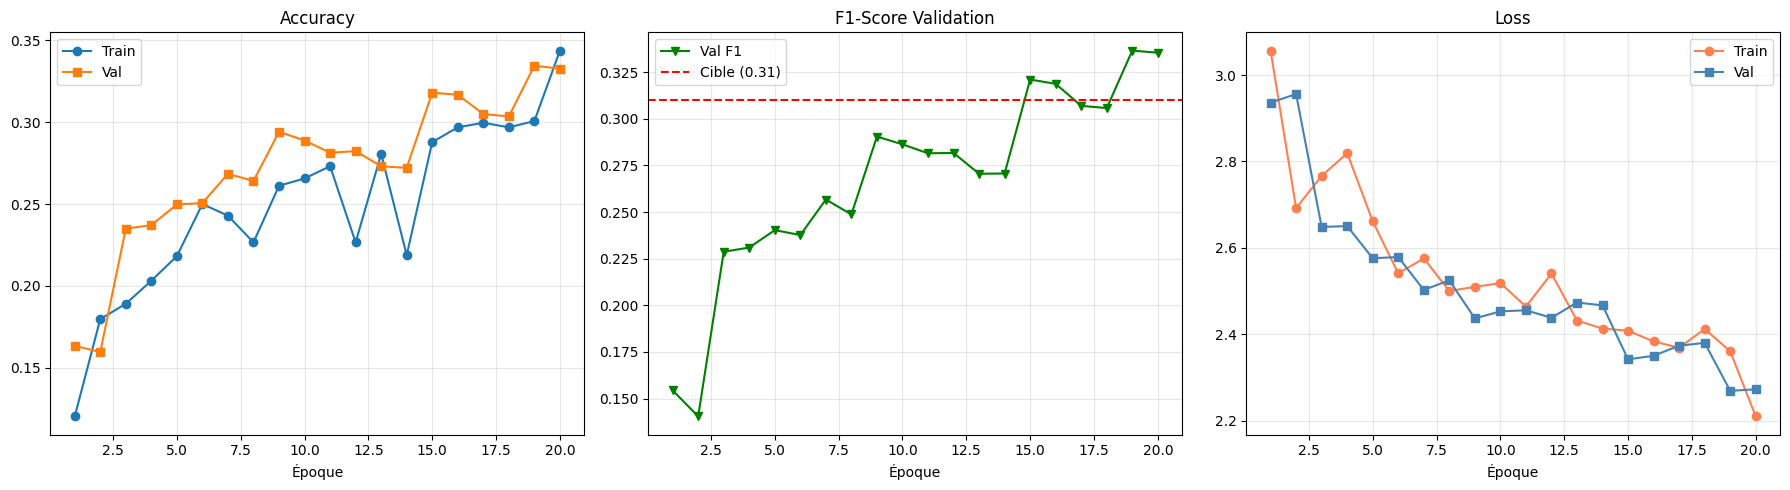

Meilleur val F1: 0.3365 (époque 19)


In [13]:
history = checkpoint.load_history()

if history:
    epochs_range = range(1, len(history['train_loss']) + 1)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].plot(epochs_range, history['train_acc'], label='Train', marker='o')
    axes[0].plot(epochs_range, history['val_acc'],   label='Val',   marker='s')
    axes[0].set_title('Accuracy'); axes[0].set_xlabel('Époque')
    axes[0].legend(); axes[0].grid(alpha=0.3)

    axes[1].plot(epochs_range, history['val_f1'], label='Val F1', marker='v', color='green')
    axes[1].axhline(y=0.31, color='red', linestyle='--', label='Cible (0.31)')
    axes[1].set_title('F1-Score Validation'); axes[1].set_xlabel('Époque')
    axes[1].legend(); axes[1].grid(alpha=0.3)

    axes[2].plot(epochs_range, history['train_loss'], label='Train', marker='o', color='coral')
    axes[2].plot(epochs_range, history['val_loss'],   label='Val',   marker='s', color='steelblue')
    axes[2].set_title('Loss'); axes[2].set_xlabel('Époque')
    axes[2].legend(); axes[2].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'training_history.png', dpi=150, bbox_inches='tight')
    plt.show()

    best_epoch = int(np.argmax(history['val_f1'])) + 1
    print(f"Meilleur val F1: {max(history['val_f1']):.4f} (époque {best_epoch})")
else:
    print("Pas d'historique trouvé")

## 🎯 Évaluation Test

In [14]:
model = checkpoint.load_model()

test_gen.reset()
y_pred_proba = model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = test_gen.classes

test_f1  = f1_score(y_true, y_pred, average='weighted', zero_division=0)
test_acc = accuracy_score(y_true, y_pred)

print(f"\n📊 Test - F1: {test_f1:.4f} | Accuracy: {test_acc:.4f}")

checkpoint.log['test_f1']  = float(test_f1)
checkpoint.log['test_acc'] = float(test_acc)
checkpoint.save_log()

📂 Chargement: lenet_baseline_001.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 550s 8s/step

📊 Test - F1: 0.3305 | Accuracy: 0.3308


## 📋 Rapport & Matrice Confusion

In [15]:
# Créer les labels lisibles
class_labels = [prdtypecode_labels[int(c)] for c in classes]

report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
print(report)
with open(OUTPUT_DIR / 'classification_report.txt', 'w') as f:
    f.write(report)
print("✅ Sauvegardé: classification_report.txt")

                                precision    recall  f1-score   support

                   Livre usagé     0.3054    0.2926    0.2989       311
Jeux vidéo et accessoires tech     0.2430    0.4502    0.3156       251
        Accessoires de console     0.1650    0.3036    0.2138       168
         Console de jeux vidéo     0.0819    0.3976    0.1358        83
          Statuette / Figurine     0.3913    0.2697    0.3193       267
       Cartes collectionnables     0.6925    0.7449    0.7178       396
                 Jeux de table     0.0774    0.1579    0.1039        76
    Jouets enfants et costumes     0.2418    0.0452    0.0761       487
               Jeux de société     0.1132    0.0870    0.0984       207
          Jouets électroniques     0.3404    0.3842    0.3609       505
            Bas et chaussettes     0.1154    0.2963    0.1661        81
  Jeux extérieurs et vêtements     0.1373    0.1406    0.1389       249
            Articles pour bébé     0.2667    0.1481    0.1905  

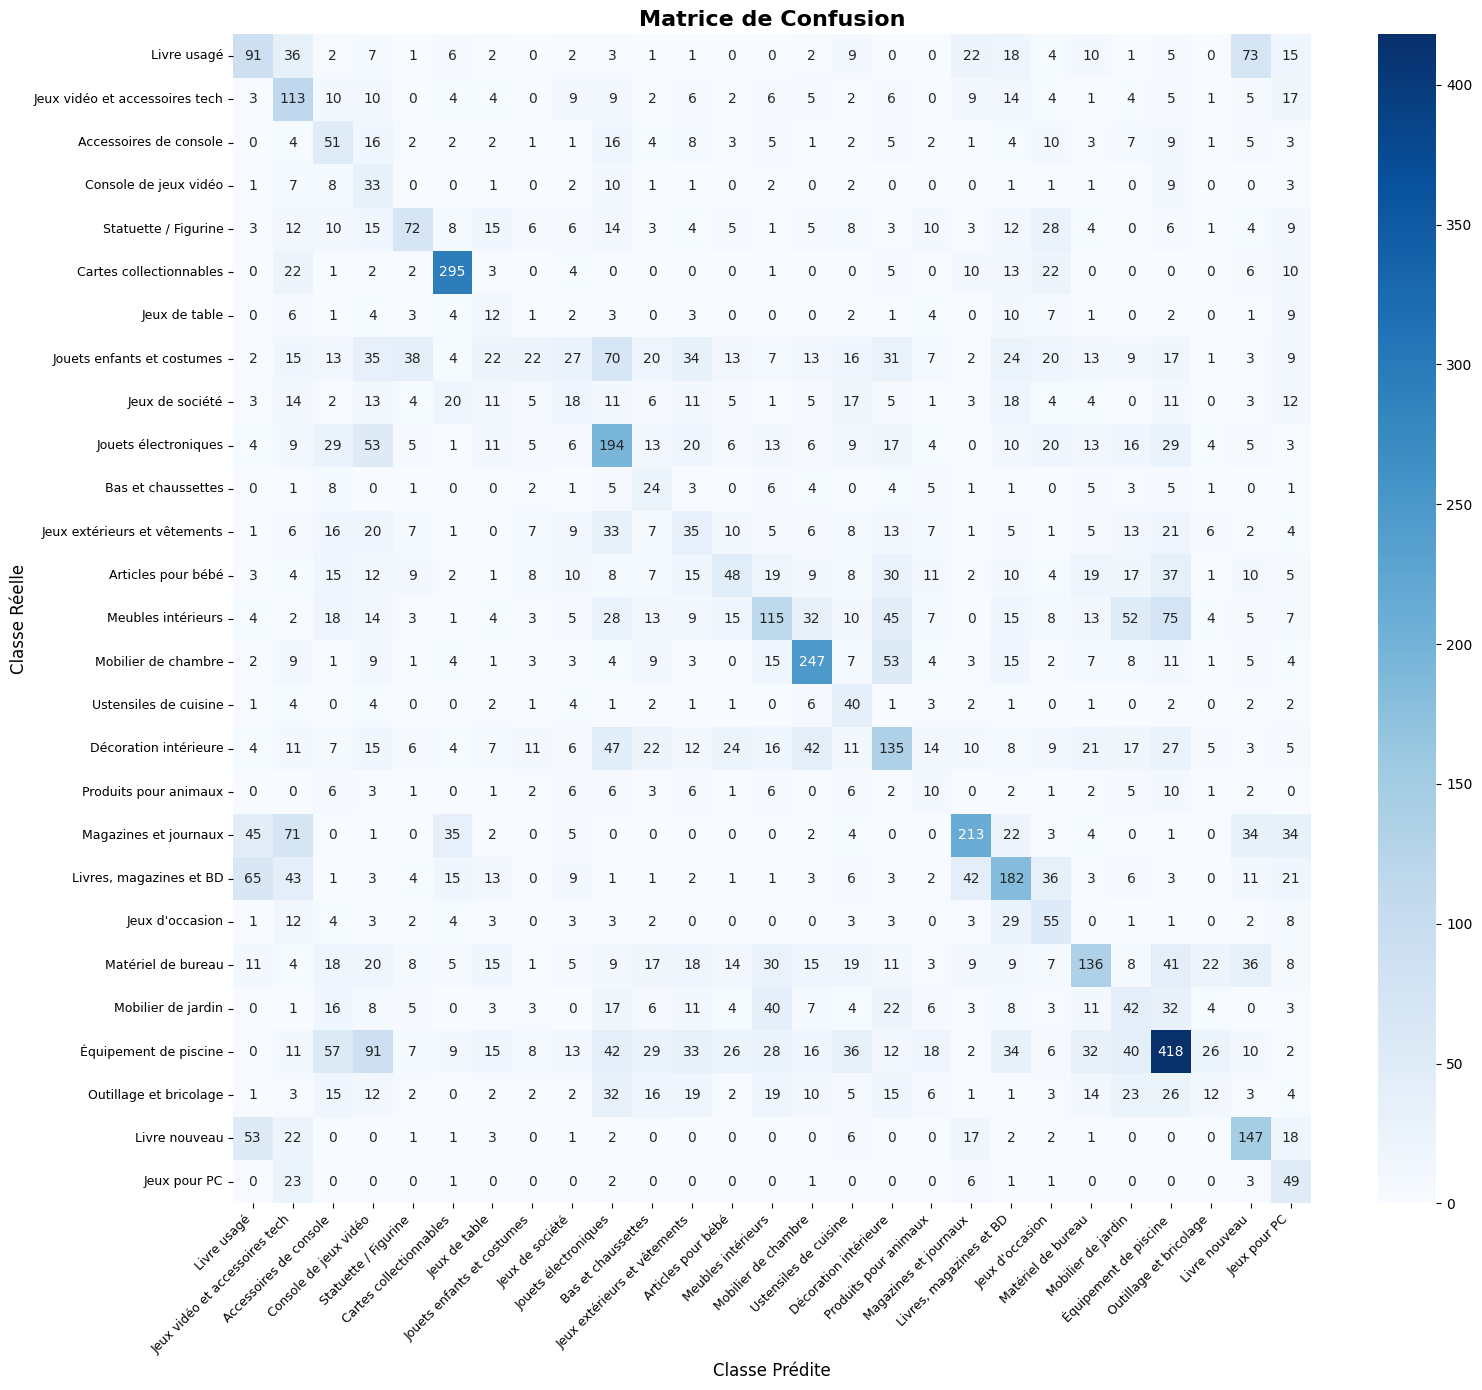

In [16]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matrice de Confusion', fontsize=16, fontweight='bold')
plt.xlabel('Classe Prédite', fontsize=12)
plt.ylabel('Classe Réelle', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

## 📋 Résumé Final

In [17]:
print("=" * 70)
print("🏆 RÉSULTATS FINAUX - LENET BASELINE")
print("=" * 70)
print(f"Train: {len(df_train):,} | Val: {len(df_val):,} | Test: {len(df_test):,}")
print(f"Époques: {checkpoint.log['epochs_done']}/{CONFIG['epochs']}")
print(f"Meilleur val F1: {checkpoint.log['best_val_f1']:.4f} (époque {checkpoint.log.get('best_epoch', 0)})")
print(f"\n🎯 Test F1:  {test_f1:.4f}")
print(f"   Test Acc: {test_acc:.4f}")

diff = test_f1 - 0.31
print(f"\n📈 Original: 0.3100 | Nous: {test_f1:.4f} | Diff: {diff:+.4f}")
if   abs(diff) <= 0.02: print("✅ Reproduction réussie!")
elif test_f1 > 0.31:    print("🎉 Performance dépassée!")
else:                   print("⚠️ En dessous - vérifier prétraitement")
print("=" * 70)

🏆 RÉSULTATS FINAUX - LENET BASELINE
Train: 109,566 | Val: 8,492 | Test: 8,492
Époques: 20/20
Meilleur val F1: 0.3365 (époque 19)

🎯 Test F1:  0.3305
   Test Acc: 0.3308

📈 Original: 0.3100 | Nous: 0.3305 | Diff: +0.0205
🎉 Performance dépassée!
